In [1]:
"""
Fitting the xG model
Need to run 3xGModel.py first to load data.
"""
#The basics
import pandas as pd
import numpy as np
import json

#Plotting
import matplotlib.pyplot as plt

#Statistical fitting of models
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss, make_scorer, brier_score_loss
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from joblib import dump, load
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
# monkey patch for bayesseachcv (https://github.com/scikit-optimize/scikit-optimize/issues/902)
from numpy.ma import MaskedArray
import sklearn.utils.fixes
sklearn.utils.fixes.MaskedArray = MaskedArray
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the data
cwd = os.getcwd()
df = pd.read_parquet(os.path.join(cwd, 'data', 'shots.parquet'))
df.drop(['match_id', 'statsbomb_id', 'statsbomb_team_id', 'player_id_statsbomb', 'competition_gender', 'team_name',
         'player_id', 'firstName', 'middleName', 'lastName', 'Name', 'dataset', 'wyscout_id', 'wyscout_team_id', 'team_id',
         'player_id_wyscout','competition_name','minute','shot_zone'], axis=1, inplace=True)
mask_penalty = (df.shot_type_name=='penalty')
df_penalty = df[mask_penalty].copy()
df_penalty.drop(['assist_type', 'pass_end_y', 'pass_end_x', 'pass_switch', 'pass_cross', 'pass_cut_back',
         'pass_height_name', 'pass_technique_name', 'carry_length', 'shot_open_goal', 'shot_one_on_one', 'under_pressure',
         'area_shot', 'area_goal', 'n_angle', 'goalkeeper_x','goalkeeper_y','smart_pass',
         'shot_zone_number','shot_zone_player_number'], axis=1, inplace=True)
df_non_penalty = df[~mask_penalty].copy()
df_non_penalty.drop(['penalty_number'], axis=1, inplace=True)
X_penalty = df_penalty.drop('goal', axis=1)
y_penalty = df_penalty.goal
X = df_non_penalty.drop('goal', axis=1)
y = df_non_penalty.goal

In [3]:
df_non_penalty.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64663 entries, 5 to 65787
Data columns (total 43 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   eventSec                 64663 non-null  float64
 1   period                   64663 non-null  float64
 2   goal                     64663 non-null  bool   
 3   shot_type_name           64663 non-null  object 
 4   x                        64663 non-null  float64
 5   y                        64663 non-null  float64
 6   counter_attack           64663 non-null  bool   
 7   fast_break               64663 non-null  bool   
 8   strong_foot              64663 non-null  bool   
 9   body_part_name           64663 non-null  object 
 10  assist_type              64663 non-null  object 
 11  pass_end_y               15635 non-null  float64
 12  pass_end_x               15635 non-null  float64
 13  pass_switch              44116 non-null  object 
 14  pass_cross            

In [7]:
df_non_penalty_goals=df_non_penalty[df_non_penalty['goal']==True]
df_non_penalty_goals

,eventSec,period,goal,shot_type_name,x,y,counter_attack,fast_break,strong_foot,body_part_name,...,area_goal,n_angle,goalkeeper_x,goalkeeper_y,smart_pass,match_moment,shot_number,shot_zone_number,shot_player_number,shot_zone_player_number
21,18.964000,1.0,True,open_play,95.4625,34.850,False,False,True,Right Foot,...,38.544291,3.0,118.9,37.9,None,0-15,2.0,2.0,2.0,2.0
26,22.560000,1.0,True,open_play,99.4000,35.360,True,False,True,Right Foot,...,26.757609,1.0,119.2,41.3,None,0-15,2.0,1.0,1.0,1.0
42,27.475000,1.0,True,open_play,101.1500,26.095,False,False,True,Right Foot,...,24.945168,1.0,119.7,42.3,None,0-15,2.0,2.0,1.0,1.0
50,33.648000,1.0,True,open_play,99.0500,30.345,False,False,False,Left Foot,...,35.389821,1.0,118.8,42.0,None,0-15,1.0,1.0,1.0,1.0
68,44.617000,1.0,True,open_play,94.5000,22.100,False,False,True,Right Foot,...,166.898316,1.0,118.0,41.0,None,0-15,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65746,3108.308801,2.0,True,open_play,98.7000,43.520,False,False,True,Right Foot,...,NaN,NaN,NaN,NaN,False,75-90,16.0,4.0,1.0,1.0
65752,3092.403842,2.0,True,open_play,92.4000,30.600,False,False,True,Right Foot,...,NaN,NaN,NaN,NaN,False,75-90,18.0,8.0,4.0,2.0
65758,3065.913803,2.0,True,open_play,97.6500,47.600,False,False,True,Right Foot,...,NaN,NaN,NaN,NaN,False,75-90,17.0,6.0,6.0,1.0
65767,3078.836672,2.0,True,direct_set_piece,79.8000,41.480,False,False,True,Left Foot,...,NaN,NaN,NaN,NaN,None,75-90,19.0,3.0,4.0,1.0


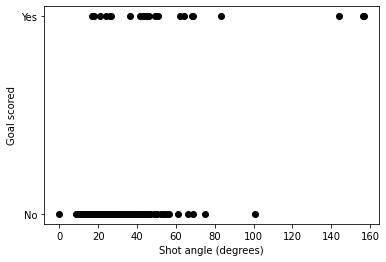

In [4]:
#Get first 200 shots
shots_200=df_non_penalty.iloc[:200]

#Plot first 200 shots goal angle
fig,ax=plt.subplots(num=1)
ax.plot(shots_200['visible_angle']*180/np.pi, shots_200['goal'], linestyle='none', marker= '.', markerSize= 12, color='black')
ax.set_ylabel('Goal scored')
ax.set_xlabel("Shot angle (degrees)")
plt.ylim((-0.05,1.05))
ax.set_yticks([0,1])
ax.set_yticklabels(['No','Yes'])
plt.show()

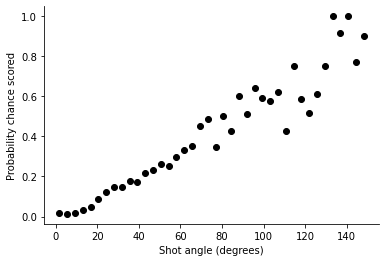

In [8]:
#Show empirically how goal angle predicts probability of scoring
shotcount_dist=np.histogram(df_non_penalty['visible_angle']*180/np.pi,bins=40,range=[0, 150])
goalcount_dist=np.histogram(df_non_penalty_goals['visible_angle']*180/np.pi,bins=40,range=[0, 150])
prob_goal=np.divide(goalcount_dist[0],shotcount_dist[0])
angle=shotcount_dist[1]
midangle= (angle[:-1] + angle[1:])/2
fig,ax=plt.subplots(num=2)
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', markerSize= 12, color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Shot angle (degrees)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [9]:
# Code commented out here, because only for illustrative purposes.
#Try some models by hand
#First try a linear model
#This is NOT a good model because a probability can't be less than zero or more than one
#Intercept and Slope
#b=[-0.05, 1/125]
#x=np.arange(150,step=0.1)
#y= b[0] + b[1]*x 
#ax.plot(x, y, linestyle='solid', color='black')

#Now try sigmoid model
#This is a good model but NOT a good way of fitting.
#because each point contains lots of data points
b=[3, -3]
x=np.arange(150,step=0.1)
y=1/(1+np.exp(b[0]+b[1]*x*np.pi/180)) 
ax.plot(x, y, linestyle='solid', color='black')
plt.show()

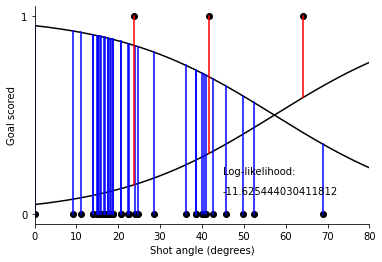

In [17]:
#Now lets look at the likelihood of model given data
xG=1/(1+np.exp(b[0]+b[1]*df_non_penalty['visible_angle'])) 
df_non_penalty = df_non_penalty.assign(xG=xG)
shots_40=df_non_penalty.iloc[:40]
fig,ax=plt.subplots(num=1)
ax.plot(shots_40['visible_angle']*180/np.pi, shots_40['goal'], linestyle='none', marker= '.', markerSize= 12, color='black')
ax.plot(x, y, linestyle='solid', color='black')
ax.plot(x, 1-y, linestyle='solid', color='black')
loglikelihood=0
for item,shot in shots_40.iterrows():
    ang=shot['visible_angle']*180/np.pi
    if shot['goal']==1:
        loglikelihood=loglikelihood+np.log(shot['xG'])
        ax.plot([ang,ang],[shot['goal'],shot['xG']], color='red')
    else:
        loglikelihood=loglikelihood+np.log(1 - shot['xG'])
        ax.plot([ang,ang],[shot['goal'],1-shot['xG']], color='blue')
    
ax.set_ylabel('Goal scored')
ax.set_xlabel("Shot angle (degrees)")
plt.ylim((-0.05,1.05))
plt.xlim((0,80))
plt.text(45,0.2,'Log-likelihood:') 
plt.text(45,0.1,str(loglikelihood))
ax.set_yticks([0,1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

                       Generalized Linear Model Regression Results                       
Dep. Variable:     ['goal[False]', 'goal[True]']   No. Observations:                64663
Model:                                       GLM   Df Residuals:                    64661
Model Family:                           Binomial   Df Model:                            1
Link Function:                             logit   Scale:                          1.0000
Method:                                     IRLS   Log-Likelihood:                -19521.
Date:                           Wed, 28 Jul 2021   Deviance:                       39042.
Time:                                   19:17:39   Pearson chi2:                 6.11e+04
No. Iterations:                                6                                         
Covariance Type:                       nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
------------------

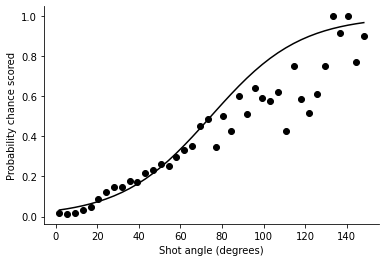

In [19]:
#Make single variable model of angle
#Using logistic regression we find the optimal values of b
#This process minimizes the loglikelihood
test_model = smf.glm(formula="goal ~ visible_angle" , data=df_non_penalty, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())        
b=test_model.params


xGprob=1/(1+np.exp(b[0]+b[1]*midangle*np.pi/180)) 
fig,ax=plt.subplots(num=1)
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', markerSize= 12, color='black')
ax.plot(midangle, xGprob, linestyle='solid', color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Shot angle (degrees)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

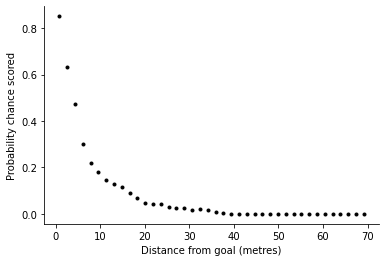

In [20]:
#Now lets look at distance from goal
#Show empirically how distance from goal predicts probability of scoring
shotcount_dist=np.histogram(df_non_penalty['distance_to_goal'],bins=40,range=[0, 70])
goalcount_dist=np.histogram(df_non_penalty_goals['distance_to_goal'],bins=40,range=[0, 70])
prob_goal=np.divide(goalcount_dist[0],shotcount_dist[0])
distance=shotcount_dist[1]
middistance= (distance[:-1] + distance[1:])/2
fig,ax=plt.subplots(num=1)
ax.plot(middistance, prob_goal, linestyle='none', marker= '.', color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Distance from goal (metres)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [21]:
#Make single variable model of distance
test_model = smf.glm(formula="goal ~ distance_to_goal" , data=df_non_penalty, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())        
b=test_model.params
xGprob=1/(1+np.exp(b[0]+b[1]*middistance)) 
ax.plot(middistance, xGprob, linestyle='solid', color='black')
plt.show() 

                       Generalized Linear Model Regression Results                       
Dep. Variable:     ['goal[False]', 'goal[True]']   No. Observations:                64663
Model:                                       GLM   Df Residuals:                    64661
Model Family:                           Binomial   Df Model:                            1
Link Function:                             logit   Scale:                          1.0000
Method:                                     IRLS   Log-Likelihood:                -19275.
Date:                           Wed, 28 Jul 2021   Deviance:                       38551.
Time:                                   19:18:57   Pearson chi2:                 6.89e+04
No. Iterations:                                7                                         
Covariance Type:                       nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
---------------

                       Generalized Linear Model Regression Results                       
Dep. Variable:     ['goal[False]', 'goal[True]']   No. Observations:                64663
Model:                                       GLM   Df Residuals:                    64660
Model Family:                           Binomial   Df Model:                            2
Link Function:                             logit   Scale:                          1.0000
Method:                                     IRLS   Log-Likelihood:                -19218.
Date:                           Wed, 28 Jul 2021   Deviance:                       38437.
Time:                                   19:20:46   Pearson chi2:                 6.51e+04
No. Iterations:                                7                                         
Covariance Type:                       nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
---------------

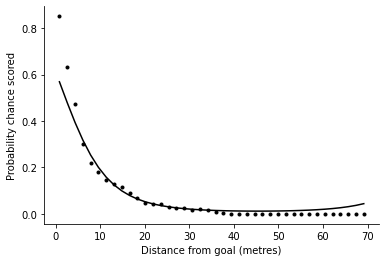

In [25]:
#Adding distance squared
squaredD = df_non_penalty['distance_to_goal']**2
df_non_penalty = df_non_penalty.assign(D2=squaredD)
test_model = smf.glm(formula="goal ~ distance_to_goal + D2" , data=df_non_penalty, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())        
b=test_model.params
xGprob=1/(1+np.exp(b[0]+b[1]*middistance+b[2]*pow(middistance,2))) 
fig,ax=plt.subplots(num=1)
ax.plot(middistance, prob_goal, linestyle='none', marker= '.', color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Distance from goal (metres)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.plot(middistance, xGprob, linestyle='solid', color='black')
plt.show()

In [28]:
#Adding even more variables to the model.
squaredX = df_non_penalty['x']**2
df_non_penalty = df_non_penalty.assign(X2=squaredX)
squaredC = df_non_penalty['C']**2
df_non_penalty = df_non_penalty.assign(C2=squaredC)
AX = df_non_penalty['visible_angle']*shots_model['X']
df_non_penalty = df_non_penalty.assign(AX=AX)

KeyError: 'C'

In [ ]:
# A general model for fitting goal probability
# List the model variables you want here
model_variables = ['Angle','Distance','X','C']
model=''
for v in model_variables[:-1]:
    model = model  + v + ' + '
model = model + model_variables[-1]


#Fit the model
test_model = smf.glm(formula="Goal ~ " + model, data=shots_model, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())        
b=test_model.params

In [ ]:
#Return xG value for more general model
def calculate_xG(sh):    
   bsum=b[0]
   for i,v in enumerate(model_variables):
       bsum=bsum+b[i+1]*sh[v]
   xG = 1/(1+np.exp(bsum)) 
   return xG   

In [ ]:
#Add an xG to my dataframe
xG=shots_model.apply(calculate_xG, axis=1) 
shots_model = shots_model.assign(xG=xG)

In [ ]:
#Create a 2D map of xG
pgoal_2d=np.zeros((65,65))
for x in range(65):
    for y in range(65):
        sh=dict()
        a = np.arctan(7.32 *x /(x**2 + abs(y-65/2)**2 - (7.32/2)**2))
        if a<0:
            a = np.pi + a
        sh['Angle'] = a
        sh['Distance'] = np.sqrt(x**2 + abs(y-65/2)**2)
        sh['D2'] = x**2 + abs(y-65/2)**2
        sh['X'] = x
        sh['AX'] = x*a
        sh['X2'] = x**2
        sh['C'] = abs(y-65/2)
        sh['C2'] = (y-65/2)**2
        
        pgoal_2d[x,y] =  calculate_xG(sh)

(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(pgoal_2d, extent=[-1,65,65,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=0.3)
fig.colorbar(pos, ax=ax)
ax.set_title('Probability of goal')
plt.xlim((0,66))
plt.ylim((-3,35))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
fig.savefig('Output/goalprobfor_' + model  + '.pdf', dpi=None, bbox_inches="tight")   

In [1]:
pip install FCPython

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement FCPython (from versions: none)
ERROR: No matching distribution found for FCPython
